In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date

pd.set_option('display.max_rows', 10)

In [3]:
#set conditions for a single timeseries
location = 'LIB'  #see reservoir dataframe below for options
startyr = 1929
endyr = 2008
special_years = [1961, 1981, 1999]  #will be highlight on hydrograph

#set file locations
filepath = '/Users/vano/Dropbox/raid/rmjoc2/%s.csv'
filename = 'nrni/NRNI_Flows_1929-2008_Corrected_08-2016'
filepath%filename

'/Users/vano/Dropbox/raid/rmjoc2/nrni/NRNI_Flows_1929-2008_Corrected_08-2016.csv'

In [2]:
#Information on possible locations and time periods

nongcm = ['nrni','livneh']
gcm = ['xxx', 'xxx']

reservoir = [{'LIB': 'Libby', 'DWO': 'Dworshak'} , # name
             {'LIB': 'LIB5N', 'DWO': 'XXX'},  # month forecast period starts
             {'LIB': 4, 'DWO': 4},  # month forecast period starts
             {'LIB': 8, 'DWO': 7}]  # month forecast period ends
reservoir = pd.DataFrame(reservoir, index=['name', 'nrni_name', 'm_start', 'm_end'])


#DO TO:
#include values here in scripts, have done some but need to do nrni+
#add gcm and rcp information

In [4]:
#Read in files (currently set up for either UW simulations or NRNI)

#If flows from UW simulations
#
#

#If flows from NRNI
df = pd.read_csv(filepath%filename, skiprows=range(1, 7), usecols=range(1,199))
nrni=df[reservoir.loc["nrni_name","%s" % (location)]]


#note: nrni dataset had funny date assignment, since only have to read in once, manually assigning them
rng = pd.date_range('07/1/1928', periods=29312, freq='D')
ts = pd.Series(nrni.values, index=rng)  
ts = ts.astype(np.float)

#TO DO:
# add UW file read in

In [5]:
# helper functions for finding day of water year and water year

def water_day(indate):
    doy = indate.timetuple().tm_yday
    if doy >= 274:
        outdate = doy - 274
    else:
        outdate = doy + 91
    return outdate

def water_year(year, month):
    if month > 9:
        return year + 1
    return year

In [11]:
tdf = ts.to_frame('streamflow')
tdf['wyear'] = [water_year(i.year, i.month) for i in tdf.index]
tdf['dowy'] = [water_day(i) for i in tdf.index]

In [7]:
twy = pd.pivot_table(tdf, index='dowy', columns='wyear')['streamflow']
twy

wyear,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,...,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
dowy,,,,,,,,,,,,,,,,,,,,,
0,4102,NaN,3582,4185,4173,NaN,8143,3805,3794.5,NaN,...,6918,5751,NaN,3090,4688,6495,NaN,12906,4081,4520
1,NaN,4010,3582,4168,3671,4312,8040,3789,4076.0,3211,...,1390,3673,5979,1859,4255,3543,7366,13915,4823,4595
2,NaN,4010,3582,4133,3628,4312,7920,3815,3997.0,3235,...,5011,4583,5147,3100,4261,3125,8258,13854,4829,5649
3,NaN,4257,3582,4099,3527,4245,8092,3789,3997.0,3302,...,3746,5718,5147,2278,5338,3968,7818,10467,3767,6493
4,NaN,4257,3582,4168,3517,4245,8281,3704,3935.0,3312,...,4591,5273,5563,3100,4473,3235,7046,9189,4189,3541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,4351,4525,4822,4113,4874,7569,4339,4595,3609.0,4291,...,7000,5578,4537,4679,4928,11345,6812,5546,3851,5743
361,4351,4237,4822,3995,4802,7517,4238,4459,3623.0,4213,...,5525,4948,4123,3590,3878,11791,8665,4167,4280,6601
362,4351,4237,4668,3928,4730,7449,4137,4393,3561.0,4195,...,5660,5365,2266,3380,4514,9562,2938,4553,4275,5310


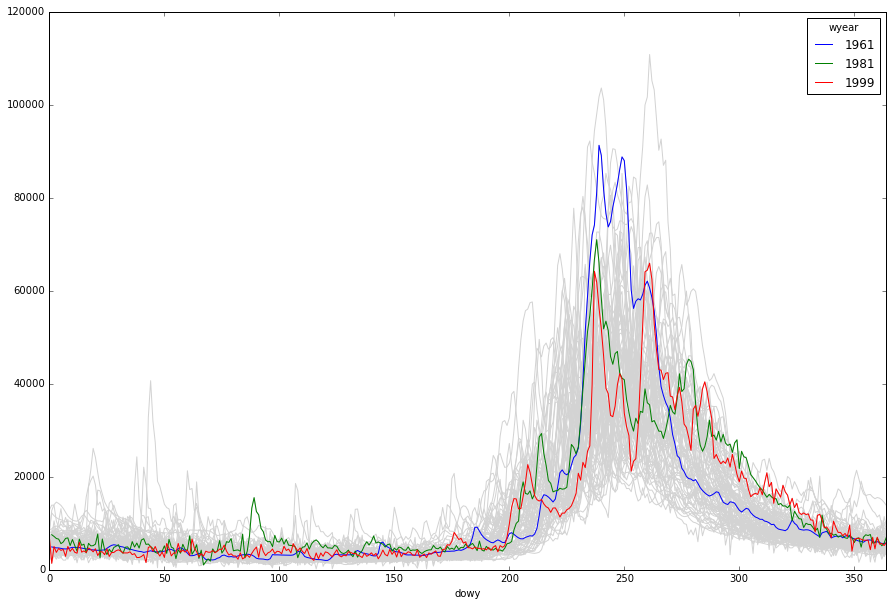

In [12]:
#hydrographs, all years in dataset

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

twy.plot(c='lightgray', legend=False, ax=ax)
twy[special_years].plot(legend=True, ax=ax)

#XXX TO DOS:
# add x axis label, y axis change to day of water year
# eventually make y axis dates
# set up to look at smaller period of time
# make font bigger
# get it to print to file
# add median

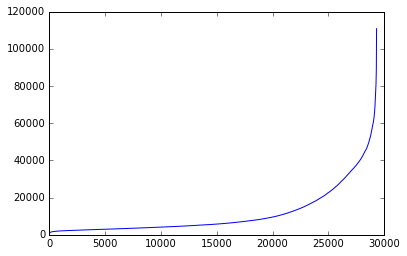

In [9]:
#flow duration curve

x = df.sort_values(by="LIB5N")
dailysort=x['LIB5N']
plt.plot(dailysort.values) 

#TO DO:
# make an excedence
# add proper labels
# read in ts (not NRNI specific)
# add plot as an object 

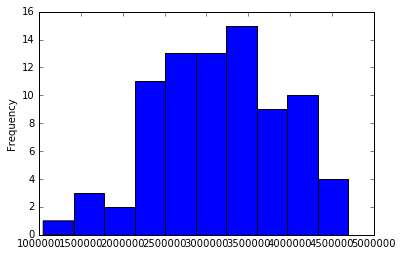

In [10]:
tmm = ts.resample('1MS', how='sum')
tmm[(tmm.index.month >= 4) & (tmm.index.month <= 8)].resample('AS', how='sum').plot.hist()

#TO DO:
#make more general and set values for Libby and Dworshak
#make it so it is weighted by month